Epoch 1/20


C:\Users\kgg07\anaconda3\envs\learning3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.1384 - val_loss: 0.0199
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0150 - val_loss: 0.0086
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0089 - val_loss: 0.0031
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0039 - val_l

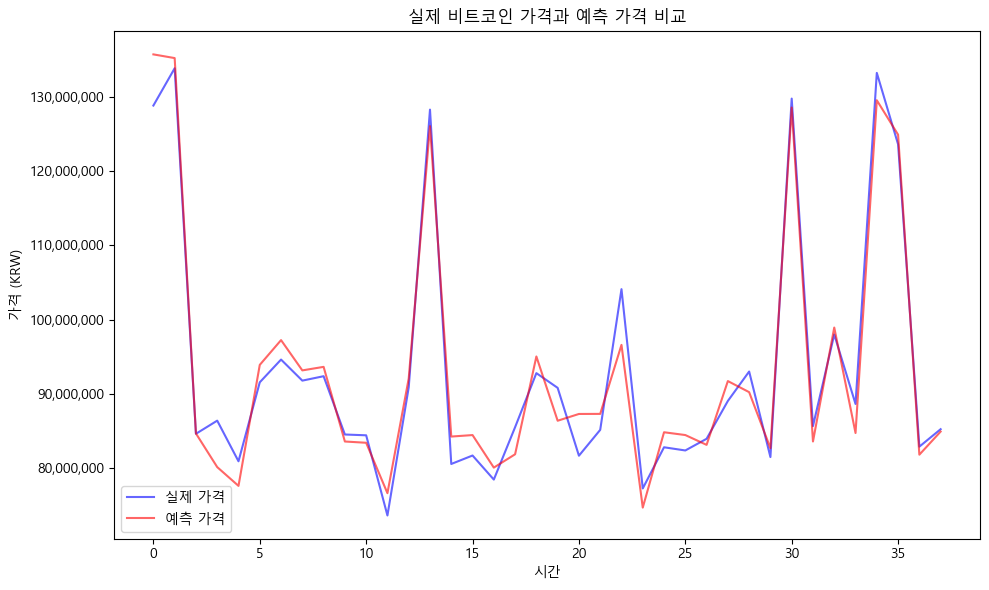

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import requests

# 그래프 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 업비트 데이터를 가져오는 함수
def fetch_upbit_data(market="KRW-BTC", count=200):
    url = "https://api.upbit.com/v1/candles/days"
    params = {"market": market, "count": count}
    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(f"업비트 API에서 데이터를 가져오지 못했습니다. 상태 코드: {response.status_code}")
        return None

    data = response.json()
    df = pd.DataFrame(data)
    df = df[["candle_date_time_kst", "trade_price"]]
    df.columns = ["date", "price"]
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df.sort_values(by="date", inplace=True)
    return df

# BTC/KRW 시장 데이터 가져오기
df_price = fetch_upbit_data()
if df_price is None:
    raise ValueError("업비트 데이터를 가져오지 못했습니다.")

# 데이터 스케일링
scaler = MinMaxScaler()
df_price['scaled_price'] = scaler.fit_transform(df_price['price'].values.reshape(-1, 1))

# 시퀀스 데이터 생성 함수 정의
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# 멀티모달 데이터 준비
sequence_length = 10
X, y = create_sequences(df_price['scaled_price'].values, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GRU 모델 생성
model = Sequential([
    GRU(128, input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# 예측값과 실제값 복원
predictions = model.predict(X_test)
original_scale_predictions = scaler.inverse_transform(predictions)
original_scale_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 결과 출력
print("샘플 예측값과 실제값:")
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:,.2f}, 실제값: {true[0]:,.2f}")

# 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(len(original_scale_y_test)), original_scale_y_test, label='실제 가격', color='blue', alpha=0.6)
plt.plot(range(len(original_scale_predictions)), original_scale_predictions, label='예측 가격', color='red', alpha=0.6)

# Y축 포맷 설정
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('실제 비트코인 가격과 예측 가격 비교')
plt.xlabel('시간')
plt.ylabel('가격 (KRW)')
plt.legend()
plt.tight_layout()
plt.show()
